In [18]:
import subprocess
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import re
import sys, tqdm

sys.path.append('../pipeline_scripts')
from plotting_setup import *

In [2]:
def get_df(folder, data_folder):
    directory = data_folder + folder
    output = subprocess.run(['ls', '-lhrt', directory], capture_output=True, text=True).stdout.strip().split('\n')
    #The first line is the total size, skip it
    output = output[1:]

    data = []
    for line in output:
        parts = line.split()
        # The columns are:
        # [0] permissions, [1] links, [2] owner, [3] group, [4] size, [5] month, [6] day, [7] time/year, [8:] name
        permissions = parts[0]
        links = int(parts[1])
        owner = parts[2]
        group = parts[3]
        size = parts[4]
        month = parts[5]
        day = parts[6]
        time_or_year = parts[7]
        name = ' '.join(parts[8:])
        data.append([permissions, links, owner, group, size, month, day, time_or_year, name])

    columns = ['Permissions', 'Links', 'Owner', 'Group', 'Size', 'Month', 'Day', 'Time', 'Name']
    df = pd.DataFrame(data, columns=columns)
    return df

In [52]:
def speed_analysis(run, data_folder = '/groups/astro/kxm508/codes/dispatch2/experiments/ISM/data/'):
    run = run + '/'
    df = get_df(folder = run, data_folder = data_folder)

    #Pattern is slumfile float followed by the filetype
    logfile_pattern = r'\d{8}\.log$'
    logfiles_df = df[df['Name'].str.contains(logfile_pattern, regex=True)]

    #Snap pattern is the files only with five digits
    snap_pattern = r'^\d{5}$'
    snaps_df = df[df['Name'].str.contains(snap_pattern, regex=True)]
    sorted_snaps = snaps_df.iloc[np.argsort(snaps_df['Name'].astype(float))][1:]
    
    last_snap = subprocess.run(['less', data_folder + run + '/last.snap'], capture_output=True, text=True).stdout.strip().split('\n')[0]
    first_snap = sorted_snaps['Name'].iloc[0]
    n_snaps = int(float(last_snap) - float(first_snap)) + 1
    sn_time = np.full([n_snaps], np.nan)
    sn_float = sn_time.copy()

    start_index = 0
    last_time = 0
    pattern_time_logfilename = r'\d{6}\_\d{4}'
    date_format ='%y%m%d_%H%M'

    for i, logfile in enumerate(logfiles_df['Name']):
        str_time_started = re.search(pattern_time_logfilename, logfile).group()
        logfile_started = datetime.strptime(str_time_started, date_format)
        year = logfile_started.year
        x = logfiles_df.iloc[i]
        time_str = f"{x['Month']} {x['Day']} {year} {x['Time']}"
        logfile_ended = datetime.strptime(time_str, '%b %d %Y %H:%M')  

        for j in range(start_index, len(sorted_snaps['Name'])):
            snap = sorted_snaps.iloc[j]['Name']
            if snap == '00000': continue
            if float(snap) > float(last_snap): break
            
            ### The snap folders get modified as you load a snapshort so the timestamp of stars.txt must be used ###
            snap_folder = get_df(run + snap, data_folder)
            try: s = snap_folder[snap_folder['Name'] == 'stars.txt'].iloc[0]
            except: 
                continue
            
            snap_time_str = f"{s['Month']} {s['Day']} {year} {s['Time']}"
            snap_abstime = datetime.strptime(snap_time_str, '%b %d %Y %H:%M')
            if snap_abstime > logfile_ended: break
            else:
                time_diff = (snap_abstime - logfile_started).total_seconds() / 3600
                sn_float[j] = float(snap); 
                sn_time[j] = time_diff + last_time
        start_index = j
        last_time += time_diff

    return sn_time, sn_float


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


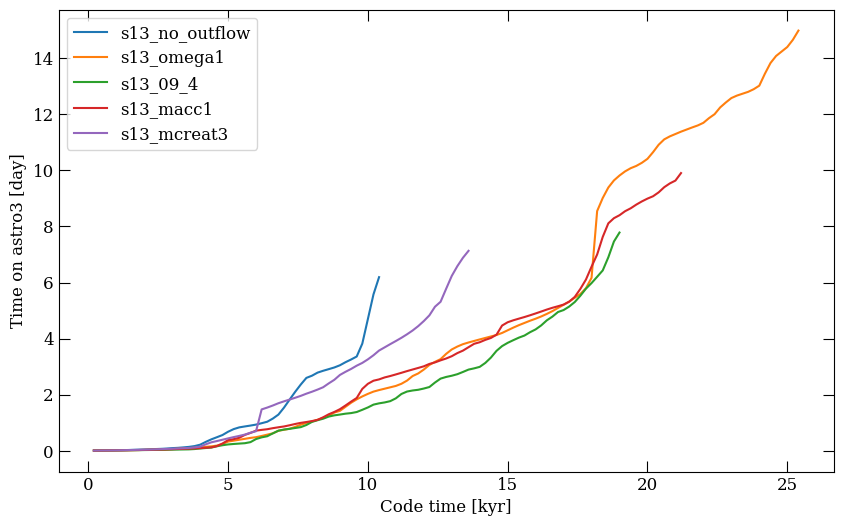

In [60]:
runs_to_compare = ['s13_no_outflow', 's13_omega1', 's13_09_4', 's13_macc1', 's13_mcreat3']
dict = {key: [] for key in runs_to_compare}


for run in tqdm.tqdm(dict.keys()):
    dict[run] = speed_analysis(run)

fig, axs = plt.subplots(figsize = (10,6))

for run in dict.keys():
    sn_time, sn_float = dict[run]
    code_time = np.arange(1, len(sn_time)+1)*0.2
    axs.plot(code_time, sn_time / 24, label = run) 
axs.set(xlabel = 'Code time [kyr]', ylabel = 'Time on astro3 [day]')
plt.legend()

100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


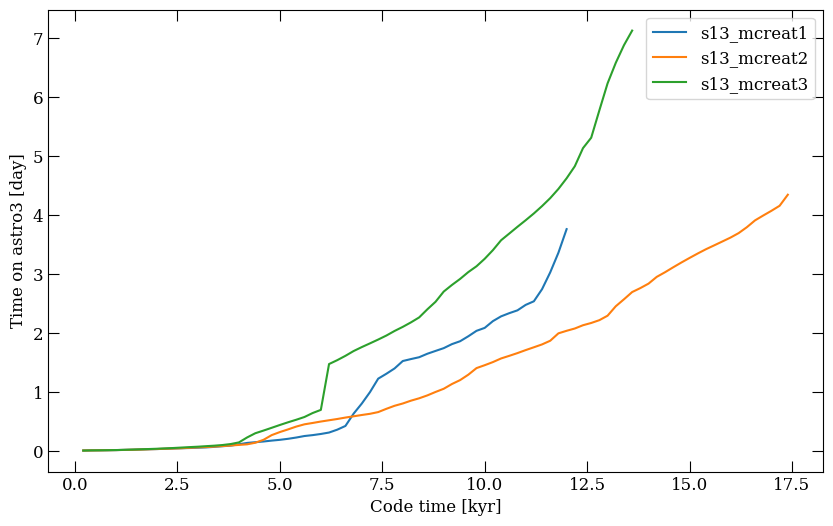

In [58]:
runs_to_compare = ['s13_mcreat1', 's13_mcreat2', 's13_mcreat3']
dict = {key: [] for key in runs_to_compare}


for run in tqdm.tqdm(dict.keys()):
    dict[run] = speed_analysis(run)

fig, axs = plt.subplots(figsize = (10,6))

for run in dict.keys():
    sn_time, sn_float = dict[run]
    code_time = np.arange(1, len(sn_time)+1)*0.2
    axs.plot(code_time, sn_time / 24, label = run) 
axs.set(xlabel = 'Code time [kyr]', ylabel = 'Time on astro3 [day]')
plt.legend()

100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


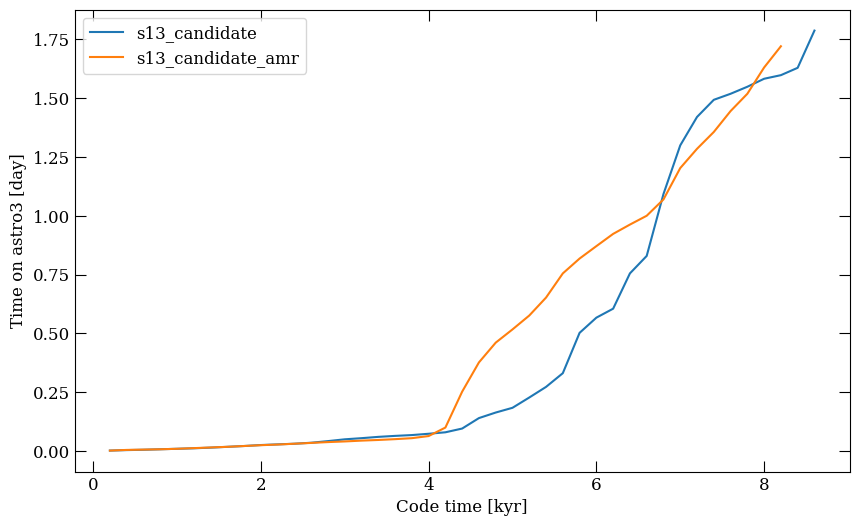

In [53]:
runs_to_compare = ['s13_candidate', 's13_candidate_amr']
dict = {key: [] for key in runs_to_compare}


for run in tqdm.tqdm(dict.keys()):
    dict[run] = speed_analysis(run)

fig, axs = plt.subplots(figsize = (10,6))

for run in dict.keys():
    sn_time, sn_float = dict[run]
    code_time = np.arange(1, len(sn_time)+1)*0.2
    axs.plot(code_time, sn_time / 24, label = run) 
axs.set(xlabel = 'Code time [kyr]', ylabel = 'Time on astro3 [day]')
plt.legend()

In [57]:
runs_to_compare = ['s13_omega1_lv19', 's13_omega1', 's13_omega1_lv21']
dict = {key: [] for key in runs_to_compare}


for run in tqdm.tqdm(dict.keys()):
    dict[run] = speed_analysis(run)

100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


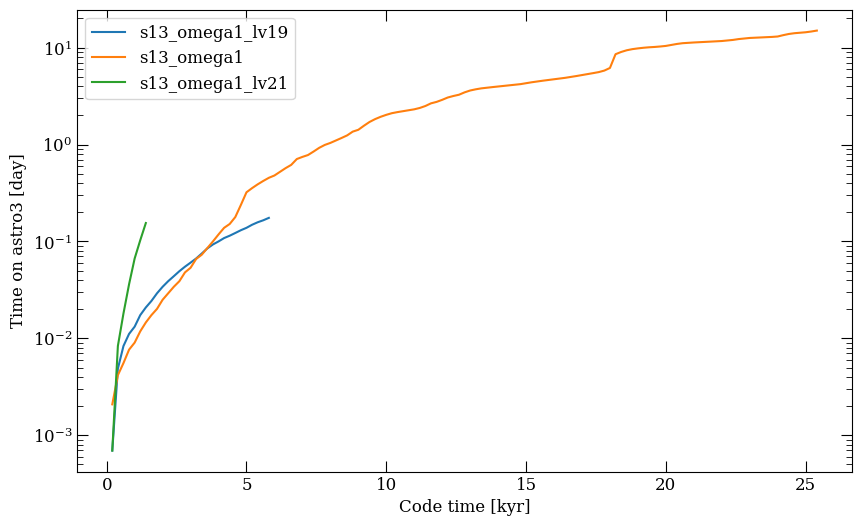

In [56]:

fig, axs = plt.subplots(figsize = (10,6))

for run in dict.keys():
    sn_time, sn_float = dict[run]
    code_time = np.arange(1, len(sn_time)+1)*0.2
    axs.plot(code_time, sn_time / 24, label = run) 
axs.set(xlabel = 'Code time [kyr]', ylabel = 'Time on astro3 [day]')
axs.set_yscale('log')
plt.legend()

100%|██████████| 4/4 [00:12<00:00,  3.11s/it]


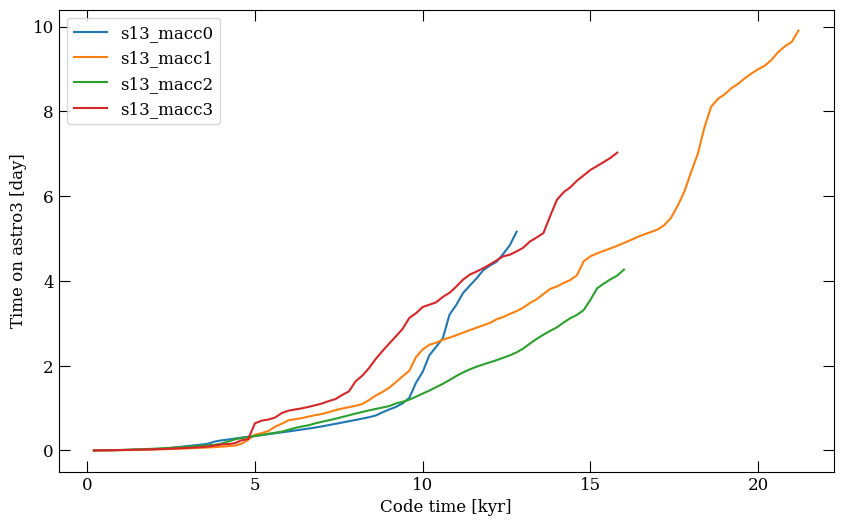

In [59]:
runs_to_compare = ['s13_macc0', 's13_macc1', 's13_macc2', 's13_macc3']
dict = {key: [] for key in runs_to_compare}


for run in tqdm.tqdm(dict.keys()):
    dict[run] = speed_analysis(run)

fig, axs = plt.subplots(figsize = (10,6))

for run in dict.keys():
    sn_time, sn_float = dict[run]
    code_time = np.arange(1, len(sn_time)+1)*0.2
    axs.plot(code_time, sn_time / 24, label = run) 
axs.set(xlabel = 'Code time [kyr]', ylabel = 'Time on astro3 [day]')
plt.legend()

100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


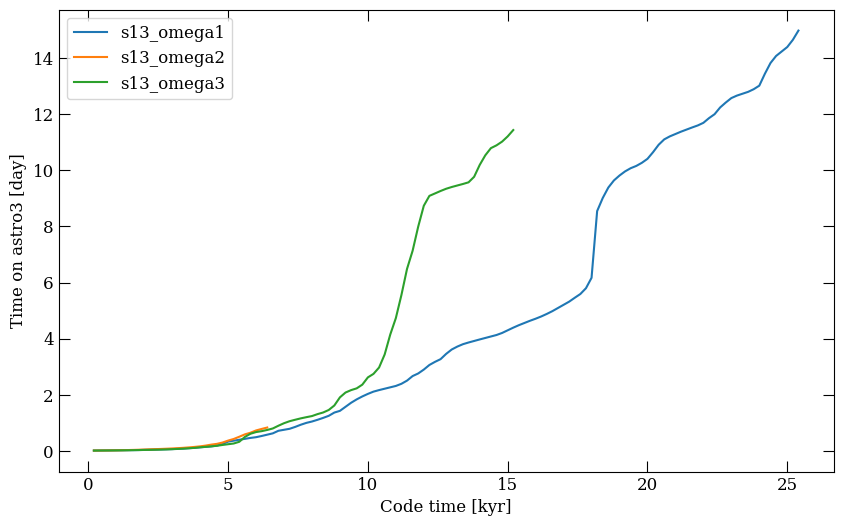

In [61]:
runs_to_compare = ['s13_omega1', 's13_omega2', 's13_omega3']
dict = {key: [] for key in runs_to_compare}


for run in tqdm.tqdm(dict.keys()):
    dict[run] = speed_analysis(run)

fig, axs = plt.subplots(figsize = (10,6))

for run in dict.keys():
    sn_time, sn_float = dict[run]
    code_time = np.arange(1, len(sn_time)+1)*0.2
    axs.plot(code_time, sn_time / 24, label = run) 
axs.set(xlabel = 'Code time [kyr]', ylabel = 'Time on astro3 [day]')
plt.legend()